In [ ]:
import kagglehub
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Enable GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
# Download latest version
dataset_path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


(200, 200, 3)
(186, 271, 3)
(225, 225, 3)
(154, 328, 3)
(183, 275, 3)
(225, 225, 3)


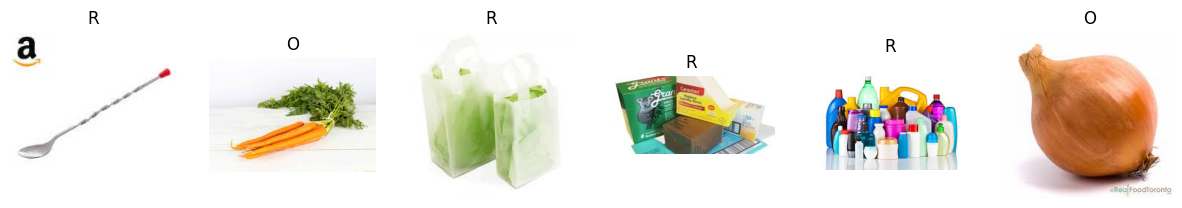

In [ ]:
# Display some random images
categories = os.listdir(os.path.join(dataset_path, 'DATASET/TRAIN'))
num_samples = 6
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
    category = random.choice(categories)
    img_name = random.choice(os.listdir(os.path.join(dataset_path, 'DATASET/TRAIN', category)))
    img_path = os.path.join(dataset_path, 'DATASET/TRAIN', category, img_name)
    img = plt.imread(img_path)
    print(img.shape)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')
plt.show()


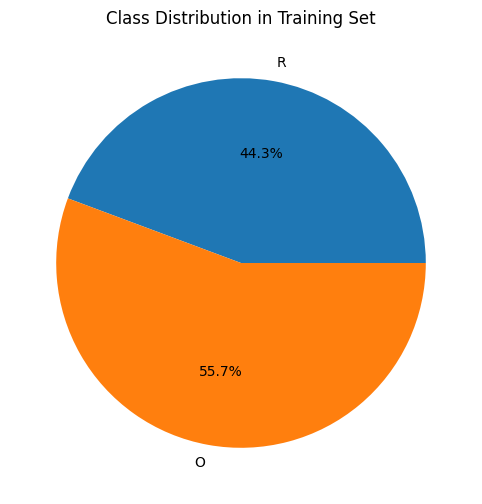

In [ ]:
# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in train and test directories
train_counts = count_images(os.path.join(dataset_path, 'DATASET/TRAIN'))
test_counts = count_images(os.path.join(dataset_path, 'DATASET/TEST'))

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', startangle=0)
plt.title("Class Distribution in Training Set")
plt.show()


In [ ]:
# Data Preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'DATASET/TRAIN'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')
val_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'DATASET/TRAIN'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'DATASET/TEST'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=GlorotUniform()),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint_callback = ModelCheckpoint(
    "best_model.h5",  # Save the best model
    monitor="val_loss",  # Track validation loss
    save_best_only=True,  # Save only if validation loss improves
    mode="min",  # Lower validation loss is better
    verbose=1
)

In [ ]:
# Define the path where you want to save the model
model_save_path = "waste_classification_model.h5"

# Train Model
epochs = 10

# Train Model on GPU
with tf.device('/GPU:0'):
    history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint_callback])


# Save the trained model
model.save(model_save_path)

print(f"Model saved at {model_save_path}")

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7386 - loss: 0.6152
Epoch 1: val_loss improved from inf to 0.48726, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7387 - loss: 0.6150 - val_accuracy: 0.7615 - val_loss: 0.4873
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8384 - loss: 0.3820
Epoch 2: val_loss improved from 0.48726 to 0.39222, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 77s 70ms/step - accuracy: 0.8384 - loss: 0.3820 - val_accuracy: 0.8291 - val_loss: 0.3922
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8571 - loss: 0.3503
Epoch 3: val_loss improved from 0.39222 to 0.38660, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.8571 - loss: 0.3503 - val_accuracy: 0.8200 - val_loss: 0.3866
Epoch 4/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8635 - loss: 0.3292
Epoch 4: val_loss improved from 0.38660 to 0.38311, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - accuracy: 0.8635 - loss: 0.3291 - val_accuracy: 0.8486 - val_loss: 0.3831
Epoch 5/10
564/565 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8807 - loss: 0.2955
Epoch 5: val_loss did not improve from 0.38311
565/565 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.8807 - loss: 0.2955 - val_accuracy: 0.8227 - val_loss: 0.4228
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8944 - loss: 0.2626
Epoch 6: val_loss did not improve from 0.38311
565/565 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - accuracy: 0.8944 - loss: 0.2626 - val_accuracy: 0.8393 - val_loss: 0.4163
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9119 - loss: 0.2219
Epoch 7: val_loss did not improve from 0.38311
565/565 ━━━━━━━━━━━━━━━━━━━━ 39s 69ms/step - accuracy: 0.9119 - loss: 0.2219 - val_accuracy: 0.8564 - val_loss: 0.3954
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9327 - loss: 0.1721
Epoch 8: val_loss did not improve f

Model saved at waste_classification_model.h5


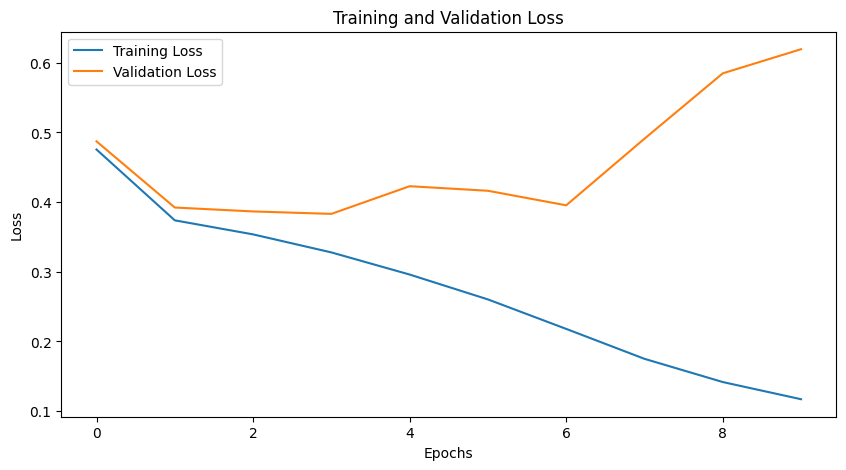

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Evaluate model on test set
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
               precision    recall  f1-score   support

           O       0.85      0.97      0.90      1401
           R       0.96      0.78      0.86      1112

    accuracy                           0.89      2513
   macro avg       0.90      0.87      0.88      2513
weighted avg       0.90      0.89      0.88      2513



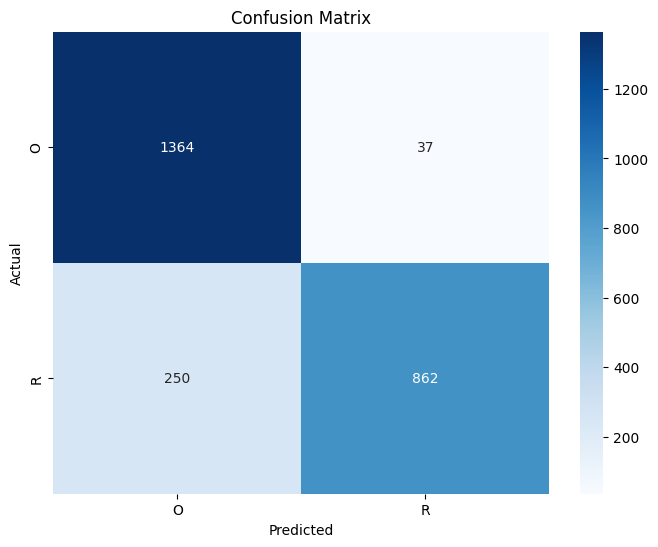

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()